# Setup

!unzip Data.zip

In [2]:
import os

CURRENT_DIR = os.getcwd()
DATA_DIR = 'Datasets/Clothes'
PATH_TO_DATA =  os.path.join(CURRENT_DIR,DATA_DIR)
print(PATH_TO_DATA)

/home/jovyan/classification/Datasets/Clothes


## Install Packages

## Import 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

## Data augmentaion and normalizaion

In [6]:
class PadTensor(object):
    def __init__(self, padding):
        # Padding can be a single integer or a tuple (left, right, top, bottom)
        self.padding = padding  

    def __call__(self, tensor):
        # Pad the tensor and specify the padding mode
        # 'constant' mode adds constant valued padding, and 0 is the padding value
        return torch.nn.functional.pad(tensor, self.padding, mode='constant', value=0)


In [7]:
# Create transform function
mean , std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   
    transforms.RandomResizedCrop(224),  # Randomly crops the resized image
    transforms.RandomHorizontalFlip(),  # Adds horizontal flip for data augmentation
    #transforms.Grayscale(num_output_channels=1),  # Converts the image to grayscale
    transforms.ToTensor(),  # Converts the image to a tensor
    PadTensor(padding=(1, 1, 1, 1)),  # Applies padding to the tensor
    transforms.Normalize(mean, std)  # Normalizes the tensor image
])

transforms_valid = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizes the image
    transforms.CenterCrop((224, 224)),  # Crops the center of the resized image
    #transforms.Grayscale(num_output_channels=1),  # Converts the image to grayscale
    transforms.ToTensor(),  # Converts the image to a tensor
    PadTensor(padding=(1, 1, 1, 1)),  # Applies padding to the tensor
    transforms.Normalize(mean, std)  # Normalizes the tensor image
])


data_transforms = {
    'train': transforms_train,
    'valid': transforms_valid,
}

## Load Data

In [273]:
image_datasets = {x: datasets.ImageFolder(os.path.join(PATH_TO_DATA, x), data_transforms[x]) for x in ['train', 'valid']}
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 14312
     Root location: /home/jovyan/classification/Datasets/Clothes/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 6101
     Root location: /home/jovyan/classification/Datasets/Clothes/valid
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    

In [274]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
print(dataset_sizes)
img, label =  image_datasets['train'][0]
print(img.shape)
print(img.numpy().transpose(1,2,0).shape)
class_names = image_datasets['train'].classes
num_classes = len(class_names)
print(num_classes)

{'train': 14312, 'valid': 6101}
torch.Size([3, 226, 226])
(226, 226, 3)
286


In [275]:
torch.manual_seed(42)
iterator = iter(dataloaders['train'])
img , label = next(iterator)
label[0].data

tensor(70)

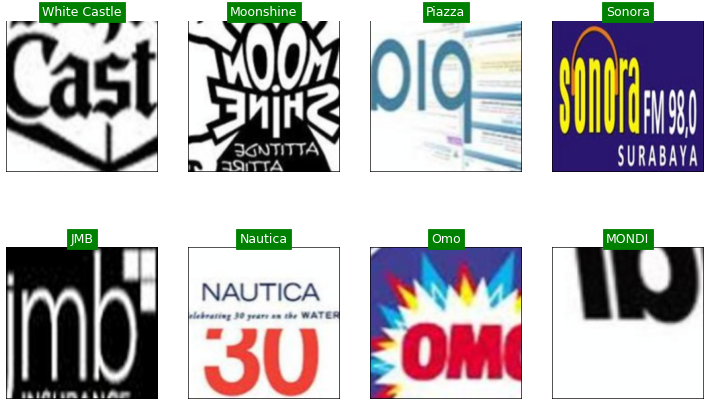

In [276]:
fig = plt.figure(figsize=(15,9))
rows, cols = 2, 4

# Load a batch of train images
iterator = iter(dataloaders['train'])
inputs, classes = next(iterator)

def imshow(input, title, ax):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    ax.imshow(input)
    ax.set_title(title, fontsize=15, color='white', backgroundcolor='green')
    ax.axis('off')  # Hide axes

# Loop through the first 8 images in the batch
for i in range(1, 9):
    ax = fig.add_subplot(rows, cols, i)
    # Display each image in its subplot
    imshow(inputs[i - 1], class_names[classes[i - 1]], ax)

plt.show()

## Load pre-trained ResNet-18 model 

In [277]:
# Load the pre-trained ResNet-18 model
model = models.resnet50(pretrained=True) # resnet18 or resnet50?


num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
print('Number of features from pre-trained model', num_features)
# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# We can use other optimizers like adam 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters
# Optimizers to compare ##TODO
optimizers = {
    'SGD': optim.SGD(model.parameters(), lr=0.0001, momentum=0.9),
    'Adam': optim.Adam(model.parameters(), lr=0.0001),
    'RMSprop': optim.RMSprop(model.parameters(), lr=0.0001)
    # Add any other optimizers you want to compare
}

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


Number of features from pre-trained model 2048
cuda:0


In [21]:
train_loader = dataloaders['train']
valid_loader = dataloaders['valid']

## Train the model on custom data 

In [ ]:
# Initialize best accuracy and initialize model weights
best_acc = 0.0
best_model_wts = model.state_dict()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'Epoch:{epoch}, {phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
        
          # Save the best model
        if phase == 'valid' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

print("Training complete!")

In [ ]:
import datetime

current_datetime = datetime.datetime.now()

# Extract the date, hour, and minute parts
current_date = current_datetime.date()
current_hour = current_datetime.hour
current_minute = current_datetime.minute
model_name = f'resnet50_{current_date}_{current_hour}:{current_minute}'

## Save the best model

In [ ]:
torch.save(best_model_wts, "models/"f'{model_name}_best.pth')

## Save the last model

In [ ]:
torch.save(model.state_dict(), "models/"f'{model_name}_last.pth')

## Clasification on unseen Image

In [11]:
import torch
from torchvision import models, transforms
from PIL import Image
from matplotlib import pyplot as plt
# Load the saved model with custom class number
model = models.resnet50(pretrained=True) #resnet50

num_features = model.fc.in_features 
print('Number of features from pre-trained model', num_features)

model.fc = nn.Linear(num_features, num_classes)  # Adjust final layer to your number of classes
model.load_state_dict(torch.load("models/"f'{model_name}_best.pth'))
model.eval()


# Create a new model with the correct final layer
new_model = models.resnet50(pretrained=True) #resnet50
new_model.fc = nn.Linear(new_model.fc.in_features, num_classes)  # Adjust to match the desired output units (how mny classes we have)

/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of features from pre-trained model 2048


NameError: name 'num_classes' is not defined

In [138]:
import torch
from torchvision import models, transforms
from PIL import Image
from matplotlib import pyplot as plt
# Load and preprocess the unseen image
image_path = 'img/target_img000393_100_5.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [139]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   
    #transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.RandomRotation(45),
    #transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.RandomRotation(85),
    #transforms.Grayscale(num_output_channels=3),
    #transforms.GaussianBlur(kernel_size = (7,13), sigma = (6 , 7)),
    transforms.ColorJitter(brightness=(0.5,1.5),contrast=(2),saturation=(1.4),hue=(-0.1,0.5)),
    transforms.ToTensor(),
    PadTensor(padding=(1, 1, 1, 1)),  # Applies padding to the tensor
    transforms.Normalize(mean, std) # normalization
])

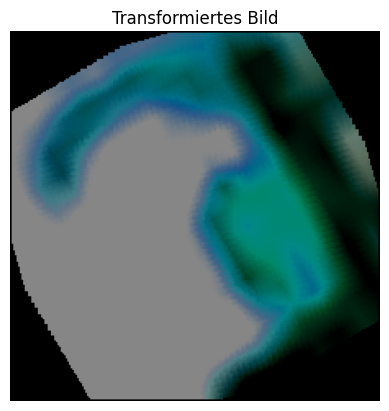

In [140]:
# Bild anzeigen
transformed_image = transforms_train(image)
def show_image(tensor_image):
    # Denormalize das Bild
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv_normalize(tensor_image)  # Denormalize
    img = img.permute(1, 2, 0)  # Wechsel von CxHxW zu HxWxC
    plt.imshow(img)
    plt.title('Transformiertes Bild')
    plt.axis('off')  # Achsen ausschalten
    plt.show()

show_image(transformed_image)

In [101]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)
# Map the predicted class to the class name
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

NameError: name 'class_names' is not defined

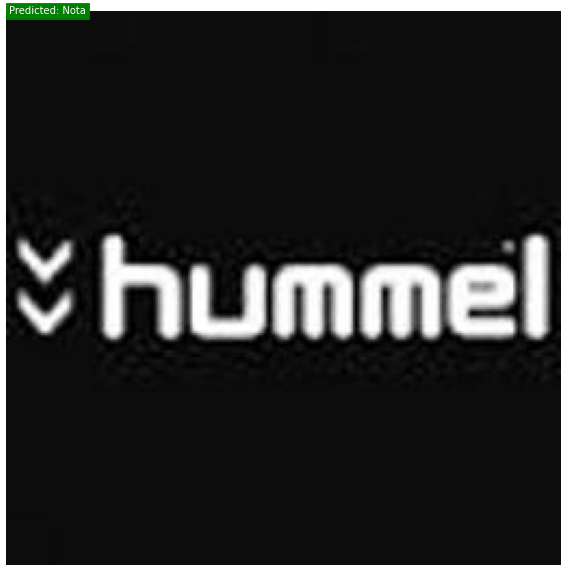

In [286]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(1 , 1 ,f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='green')
plt.show()

In [ ]:
with open("brands.txt", "r") as file:
    lines = file.readlines()

lines_upper = [line.upper() for line in lines]

unique_lines = set()
duplicate_lines = []

for line in lines_upper:
    if line in unique_lines:
        duplicate_lines.append(line)
    else:
        unique_lines.add(line)
print(f'{len(unique_lines)} Brands')